In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.INFO)

def cnn_model(features, labels, mode, config):
    #data format: (index_in_batch, height, width, channel)
    # mode: Indicate it is in training or testing or predicting

    shape = np.append([-1], features.shape[1:])
    height, width = features.shape[1], features.shape[2]
    convKernel = [3, 3]
    stridesSize = (1, 1)
    poolSize = [2, 2]
    dropout = 0.2

    # Input reshape
    input_layer = tf.cast(tf.reshape(features, shape), tf.float32)

    #Convolutional layer 1
    conv1 = tf.layers.conv2d(
            inputs = input_layer, filters = 8, kernel_size = convKernel, 
            strides = stridesSize, activation = tf.nn.relu, name = "conv1")
    
    #Convolutional layer 2
    conv2 = tf.layers.conv2d(
            inputs = conv1, filters = 16, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "conv2")

    #Pooling
    pool1 = tf.layers.max_pooling2d(
            inputs = conv2, pool_size = poolSize, strides = 2, name = "pooling1")

    #Convolutional layer 3
    conv3 = tf.layers.conv2d(
            inputs = pool1, filters = 16, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "conv3")

    dropout1 = tf.layers.dropout(inputs = conv3, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    #Convolutional layer 4
    conv4 = tf.layers.conv2d(
            inputs = dropout1, filters = 32, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "conv4")

    dropout2 = tf.layers.dropout(inputs = conv4, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    #Convolutional layer 5
    conv5 = tf.layers.conv2d(
            inputs = dropout2, filters = 32, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "conv5")

    dropout3 = tf.layers.dropout(inputs = conv5, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    pool2 = tf.layers.max_pooling2d(
            inputs = dropout3, pool_size = poolSize, strides = 2, name = "pooling2")

    #Convolutional layer 6
    conv6 = tf.layers.conv2d(
            inputs = pool2, filters = 64, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "conv6")

    dropout3 = tf.layers.dropout(inputs = conv6, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    #Convolutional layer 7
    conv7 = tf.layers.conv2d(
            inputs = dropout3, filters = 64, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "conv7")

    dropout4 = tf.layers.dropout(inputs = conv7, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    pool3 = tf.layers.max_pooling2d(
            inputs = dropout4, pool_size = poolSize, strides = 2, name = "pooling3")

    [_, height, width, channel] = pool3.get_shape().as_list()

    unsample1 = tf.image.resize_nearest_neighbor(
            images = pool3, size = ( height * 2, width * 2), name = "unsampling1")
    
    #Deconvolution layer 1
    deconv1 = tf.layers.conv2d_transpose(
            inputs = unsample1, filters = 64, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "deconv1")

    dropout5 = tf.layers.dropout(inputs = deconv1, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    #Deconvolution layer 2
    deconv2 = tf.layers.conv2d_transpose(
            inputs = dropout5, filters = 64, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "deconv2")

    dropout5 = tf.layers.dropout(inputs = deconv2, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    [_, height, width, channel] = dropout5.get_shape().as_list()
    
    unsample2 = tf.image.resize_nearest_neighbor(
            images = dropout5, size = (height * 2, width * 2), name = "unsampling2")

    #Deconvolution layer 3
    deconv3 = tf.layers.conv2d_transpose(
            inputs = unsample2, filters = 32, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "deconv3")

    dropout6 = tf.layers.dropout(inputs = deconv3, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    #Deconvolution layer 4
    deconv4 = tf.layers.conv2d_transpose(
            inputs = dropout6, filters = 32, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "deconv4")

    dropout7 = tf.layers.dropout(inputs = deconv4, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    #Deconvolution layer 5
    deconv5 = tf.layers.conv2d_transpose(
            inputs = dropout7, filters = 16, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "deconv5")

    dropout8 = tf.layers.dropout(inputs = deconv5, rate = dropout, training = (mode == tf.estimator.ModeKeys.TRAIN))

    [_, height, width, channel] = dropout8.get_shape().as_list()

    unsample3 = tf.image.resize_nearest_neighbor(
            images = dropout8, size = (height *2, width * 2), name = "unsampling3")

    #Deconvolution layer 6
    deconv6 = tf.layers.conv2d_transpose(
            inputs = unsample3, filters = 16, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "deconv6")

    #Deconvolution layer 7
    deconv7 = tf.layers.conv2d_transpose(
            inputs = deconv6, filters = 1, kernel_size = convKernel,
            strides = stridesSize, activation = tf.nn.relu, name = "deconv7")
    
    predictions = {
        "predict_lane": deconv7
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.mean_squared_error(predictions = deconv7, labels = labels)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

      # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = { "accuracy": tf.metrics.mean(tf.losses.mean_squared_error(labels=labels, predictions=predictions["predict_lane"]))}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [2]:
def main(unused_args):
    #load data
    labels = pickle.load(open("full_CNN_labels.p", "rb" ))
    labels = np.array(labels)
    labels = labels / 255
    train_images_raw = pickle.load(open("full_CNN_train.p", "rb" ))
    train_images=np.array(train_images_raw)
    
    # train data / test data = 0.8
    rate = 0.8

    # split the data
    train_data, test_data, train_label, test_label = \
    train_test_split(train_images, labels, train_size = rate, test_size = 1 - rate)

    # Add a logger
    # logging_hook = tf.train.LoggingTensorHook({"accuracy" : "metrics_acc"}, every_n_iter=10)

    #Train
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=train_data,
        y=train_label,
        batch_size=128,
        num_epochs=10,
        shuffle=True)
    
    classifier = tf.estimator.Estimator(
        model_fn= cnn_model,
        model_dir= "./tmp/lane_prediction")

    classifier.train( input_fn=train_input_fn, steps=len(train_data)/128)
    
    #Test
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = test_data,
        y = test_label,
        num_epochs = 1,
        shuffle = False)
    
    test_result = classifier.evaluate(input_fn= test_input_fn)
    print(test_result)

if __name__ == "__main__":
    tf.app.run(main)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/lane_prediction', '_save_checkpoints_steps': None, '_tf_random_seed': None, '_log_step_count_steps': 100, '_session_config': None, '_master': '', '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_is_chief': True, '_task_id': 0, '_train_distribute': None, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7c826d5908>, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_num_ps_replicas': 0, '_task_type': 'worker', '_global_id_in_cluster': 0}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./tmp/lane_prediction/model.ckpt.
INFO:tensorflow:st

SystemExit: 

/home/spencer/Documents/MachineLearning/project_venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
print(tf.__version__)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/lane_prediction', '_save_checkpoints_steps': None, '_tf_random_seed': None, '_log_step_count_steps': 100, '_session_config': None, '_master': '', '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_is_chief': True, '_task_id': 0, '_train_distribute': None, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7b7c804cf8>, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_num_ps_replicas': 0, '_task_type': 'worker', '_global_id_in_cluster': 0}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/lane_prediction/model.ckpt-80
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


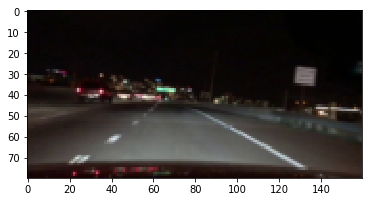

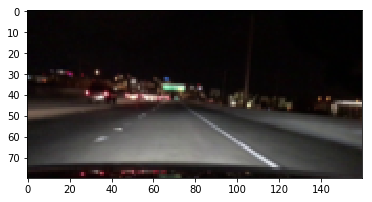

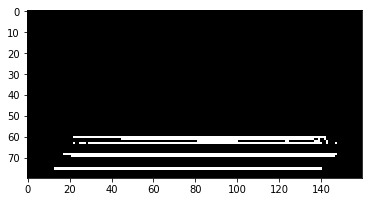

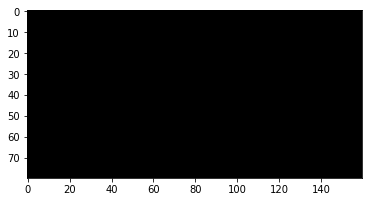

In [3]:
import matplotlib.image as mpimg

train_images_raw = pickle.load(open("full_CNN_train.p", "rb" ))

classifier = tf.estimator.Estimator(
        model_fn= cnn_model,
        model_dir= "./tmp/lane_prediction")

I = train_images_raw[0:2];
    
plt.figure()
plt.imshow(I[0])

plt.figure()
plt.imshow(I[1])


predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=np.array(I),
    num_epochs=1,
    shuffle=False)

predictions = list(classifier.predict(input_fn=predict_input_fn))
predicted_lane1 = predictions[0]['predict_lane']
G1 = np.zeros((80,160,3))
P = predicted_lane1.squeeze()
avg = np.average(P)
G1[P>avg] = [1,1,1]
G1[P<=avg] = [0,0,0]

plt.figure()
plt.imshow(G1)

predicted_lane2 = predictions[1]['predict_lane']
G2 = np.zeros((80,160,3))
P = predicted_lane2.squeeze()
G2[P>0.5] = [1,1,1]
G2[P<=0.5] = [0,0,0]

plt.figure()
plt.imshow(G2)